## Introduction

L'objectif de ce notebook est d'exposer notre démarche dans la recherche de notre modèle dans le cadre de la prédiction du métier d'un individu selon son CV. Nous avons essayé de comparer différentes méthodes d'apprentissage afin d'avoir le meilleur modèle tout en prennat en compte deux métriques: le f1_score et le score de disparité démographique (disparate impact) moyen.

In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time

In [2]:
import re
import string
from nltk.stem import WordNetLemmatizer as wnl
from nltk import word_tokenize
from nltk.corpus import stopwords
from numpy import random
from gensim.models import Doc2Vec
from sklearn import utils
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm

In [3]:
# Ce dictionnaire nous servira à construire notre tablea récapituliatif de résultats obtenus à la fin de ce notebook.
summary = {}

In [4]:
#Read our pre-cleaned data from our first round of cleaning

data1 = pd.read_pickle("../../Project_outputs/pickled_files/corpus/round1_cleaned_corpus_for_models.pkl")
# data = data.transpose()
data1.head()

Id                                        description gender  categories
0   0   she is also a ronald d asmus policy entrepren...      F   professor
1   1   he is a member of the aicpa and wicpa brent g...      M  accountant
2   2   dr aster has held teaching and research posit...      M   professor
4   3   he runs a boutique design studio attending cl...      M   architect
5   4   he focuses on cloud security identity and acc...      M   architect

## Classification en utilisant les techniques basiques de pré-traitement

In [5]:
# Scindons les données:
features = data1.description

#viriable que l'on souhaite prédire
labels1 = data1.categories

In [6]:
jobs = list(labels1.unique())

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels1, data1.index, test_size=0.33, random_state=0)

In [8]:
X_train

161948     he has published papers on presentism the pos...
147893     his primary research interests focus on theor...
113918     she graduated with honors in  having more tha...
111252     he is the residentexecutive editor of the jan...
241051     he is also a behavior management coordinator ...
                                ...                        
221542     ms west began her career as corporate attorne...
147555     he has successfully coupled business acumen w...
217453     he has broad interests in laparoscopic colon ...
54411      she received her ba from wellesley college in...
249381     his unique style can be characterized by his ...
Name: description, Length: 145454, dtype: object

In [9]:
indices_train

Int64Index([161948, 147893, 113918, 111252, 241051,  27930, 203075, 253905,
            240492, 222885,
            ...
            153364,  52430, 122154, 120002, 190689, 221542, 147555, 217453,
             54411, 249381],
           dtype='int64', length=145454)

In [10]:
print(type(indices_test))
indices_test


<class 'pandas.core.indexes.numeric.Int64Index'>


Int64Index([236912,   5595,   4495,  32989,  92688,  75392, 117226, 103618,
            183041, 218912,
            ...
            228243, 152477, 122702, 227420, 238260, 164515,  45019, 226022,
             65705, 190387],
           dtype='int64', length=71643)

In [11]:
X_test_save = X_test

In [12]:
tfidf_vect1 = TfidfVectorizer(max_features=20000, sublinear_tf=True, min_df=5, norm='l2')

In [13]:
tfidf_vect1.fit(X_train)

TfidfVectorizer(max_features=20000, min_df=5, sublinear_tf=True)

In [14]:
import pickle
import os

filename = "../../Project_outputs/pickled_files/vectorizer/round1_tfidf_vect.pkl"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'wb') as f:
    pickle.dump(tfidf_vect1, f)

In [15]:
X_train = tfidf_vect1.transform(X_train)
X_train

<145454x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 6040010 stored elements in Compressed Sparse Row format>

In [16]:
X_test = tfidf_vect1.transform(X_test)
X_test

<71643x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 2966079 stored elements in Compressed Sparse Row format>

## Sélection du modèle

Ici, nous allons tenté différents modèles et évaluer leur f1-score.

Les modèles que nous allons tester sont:
- Logistic Regression 
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest

### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
logreg1 = LogisticRegression(random_state=0, max_iter=2000, multi_class='multinomial')

In [19]:
tps0=time.perf_counter()

logreg1.fit(X_train, y_train)

tps1=(time.perf_counter()-tps0)

print(f"temps d'entrainement: {tps1}")

temps d'entrainement: 193.46162109


In [20]:
import pickle
filename = "../../Project_outputs/pickled_files/models/log_reg/model_1_trained_with_round1_cleaned_corpus_for_models.pkl"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
pickle.dump(logreg1, open(filename, 'wb'))

In [21]:
y_pred_logreg1 = logreg1.predict(X_test)
y_pred_logreg1

array(['attorney', 'professor', 'filmmaker', ..., 'journalist',
       'professor', 'filmmaker'], dtype=object)

In [22]:
print('accuracy %s' % accuracy_score(y_pred_logreg1, y_test))
print(classification_report(y_test, y_pred_logreg1,target_names=jobs))

accuracy 0.7947182557961001
                   precision    recall  f1-score   support

        professor       0.86      0.66      0.75      1050
       accountant       0.72      0.60      0.65      1918
        architect       0.84      0.89      0.86      6236
     psychologist       0.91      0.53      0.67       467
       journalist       0.87      0.66      0.75       566
          teacher       0.83      0.80      0.81      1161
            nurse       0.95      0.90      0.92      1790
         attorney       0.86      0.75      0.80       750
software_engineer       0.93      0.56      0.70       297
          painter       0.82      0.73      0.77      1344
        physician       0.85      0.52      0.64       282
     chiropractor       0.64      0.77      0.70      4085
 personal_trainer       0.83      0.74      0.78      1397
     photographer       0.87      0.81      0.84      4134
          surgeon       0.81      0.76      0.79      1463
        filmmaker       0.9

In [23]:
logreg1_f1_score = f1_score(y_test, y_pred_logreg1, average='macro')
print('f1_score: %s' % logreg1_f1_score)

f1_score: 0.7307200879711715


In [24]:
cross_logreg1 = pd.crosstab(y_pred_logreg1, y_test, rownames=['Predicted job'], colnames=['Actual job'])
cross_logreg1

Actual job         accountant  architect  attorney  chiropractor  comedian  \
Predicted job                                                                
accountant                692          8        26             0         0   
architect                  18       1143        11             1         0   
attorney                  100         45      5549            13        15   
chiropractor                0          0         1           249         0   
comedian                    3          1         2             0       371   
composer                    0          4         3             0         4   
dentist                     0          0         0             4         0   
dietitian                   0          0         4             1         1   
dj                          0          2         0             0         0   
filmmaker                   1          3        10             0        14   
interior_designer           0         15         0             0         0   
journalist                 46         48       137             5        74   
model                       2          8        11             1        21   
nurse                       7          5        22            23         0   
painter                     1         24         2             0         2   
paralegal                   0          0         5             0         0   
pastor                      5          3        10             0         1   
personal_trainer            1          0         1             2         0   
photographer               17         60        27             4        21   
physician                   5          0         5           111         0   
poet                        2          4         3             0         0   
professor                  94        286       301            25        13   
psychologist                7          5        22            10         4   
rapper                      0          0         0             0         0   
software_engineer           2        213         7             0         1   
surgeon                     0          0         1            10         0   
teacher                    47         41        75             6        24   
yoga_teacher                0          0         1             2         0   

Actual job         composer  dentist  dietitian   dj  filmmaker  ...  \
Predicted job                                                    ...   
accountant                0        4          0    1          0  ...   
architect                 2        4          0    4          0  ...   
attorney                  5       14          1    3         14  ...   
chiropractor              0        0          0    0          0  ...   
comedian                  1        0          0    2          6  ...   
composer                925        1          0   33         10  ...   
dentist                   0     1618          0    0          0  ...   
dietitian                 0        1        563    0          0  ...   
dj                        2        0          0  167          0  ...   
filmmaker                27        1          0    0        981  ...   
interior_designer         0        0          0    0          0  ...   
journalist               19       11         28   32        100  ...   
model                     2        4          0    2         11  ...   
nurse                     0        9         21    0          0  ...   
painter                   6        1          1    0         10  ...   
paralegal                 0        0          1    0          0  ...   
pastor                    1        1          0    0          0  ...   
personal_trainer          0        1          7    0          0  ...   
photographer             32        5          6   23         85  ...   
physician                 0       28         17    0          1  ...   
poet                     14        0          0    0          4  ...   
pro

In [25]:
import seaborn as sns

def plot_heatmap(cross_table, y_label, x_label, fmt='g'):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cross_table,
                annot=None,
                fmt=fmt,
                cmap='magma_r',
                linewidths=.5,
                ax=ax)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()


In [26]:
plot_heatmap(cross_logreg1, 'Actual', 'Predicted', fmt='.2%')

In [27]:
y_pred_proba_logreg1 = logreg1.predict_proba(X_test)
y_pred_proba_logreg1

array([[2.24907542e-03, 7.40664712e-04, 9.22857657e-01, ...,
        1.91644304e-03, 3.87450953e-03, 1.47221526e-04],
       [6.75179090e-05, 1.01846719e-04, 7.08391871e-04, ...,
        1.08186883e-03, 5.50428054e-04, 8.46117256e-05],
       [7.84596698e-03, 5.81313449e-03, 1.06374345e-02, ...,
        1.83338960e-02, 6.45566213e-02, 4.82790927e-02],
       ...,
       [1.62587830e-03, 6.58730958e-03, 8.07424008e-03, ...,
        8.53595953e-04, 9.59374810e-03, 2.19844754e-04],
       [2.19427478e-05, 7.18836240e-05, 4.64645893e-05, ...,
        3.42878523e-05, 7.54912406e-02, 1.15117485e-04],
       [1.41768698e-03, 1.50537169e-03, 4.36288133e-03, ...,
        1.23151104e-03, 5.52631991e-03, 3.96219227e-04]])

In [28]:
y_pred_proba_logreg1.shape

(71643, 28)

In [29]:
print("---Tableau de probabilités de prédiction d'appartenance du premier CV de test aux différents métiers: ")
y_pred_proba_logreg1[1]

---Tableau de probabilités de prédiction d'appartenance du premier CV de test aux différents métiers: 


array([6.75179090e-05, 1.01846719e-04, 7.08391871e-04, 7.62978777e-05,
       2.89849310e-05, 5.85886257e-05, 1.65936826e-04, 2.17685608e-03,
       2.23212973e-05, 1.18483819e-04, 6.36508985e-05, 8.02184937e-04,
       6.23142261e-05, 7.84622714e-03, 1.08787826e-04, 1.64245749e-04,
       7.87723725e-05, 8.47424333e-05, 8.41778180e-05, 4.09523790e-02,
       1.41073403e-04, 9.41401239e-01, 2.81966817e-03, 1.31988167e-05,
       1.35203167e-04, 1.08186883e-03, 5.50428054e-04, 8.46117256e-05])

In [30]:
log_reg_pred_prob1 = pd.DataFrame(y_pred_proba_logreg1, columns=logreg1.classes_)
log_reg_pred_prob1.head()

accountant  architect  attorney  chiropractor  comedian  composer  \
0    0.002249   0.000741  0.922858      0.000354  0.000576  0.000669   
1    0.000068   0.000102  0.000708      0.000076  0.000029  0.000059   
2    0.007846   0.005813  0.010637      0.005861  0.021621  0.011574   
3    0.001236   0.006948  0.003966      0.001605  0.000581  0.000484   
4    0.006588   0.005576  0.009606      0.014344  0.004760  0.010314   

    dentist  dietitian        dj  filmmaker  ...  photographer  physician  \
0  0.000421   0.000291  0.000252   0.000703  ...      0.001326   0.001837   
1  0.000166   0.002177  0.000022   0.000118  ...      0.000084   0.040952   
2  0.006066   0.016416  0.006695   0.358523  ...      0.038642   0.036115   
3  0.001105   0.001638  0.000299   0.000780  ...      0.001828   0.007037   
4  0.006012   0.003655  0.003858   0.008455  ...      0.015182   0.222432   

       poet  professor  psychologist    rapper  software_engineer   surgeon  \
0  0.000850   0.048523      0.001406  0.000201           0.001144  0.001916   
1  0.000141   0.941401      0.002820  0.000013           0.000135  0.001082   
2  0.029246   0.024449      0.037921  0.007181           0.004531  0.018334   
3  0.003181   0.611195      0.005553  0.000384           0.001185  0.000893   
4  0.008538   0.461024      0.027259  0.005165           0.010643  0.086435   

    teacher  yoga_teacher  
0  0.003875      0.000147  
1  0.000550      0.000085  
2  0.064557      0.048279  
3  0.089905      0.003319  
4  0.012388      0.002342  

[5 rows x 28 columns]

In [31]:
y_pred_logreg_df1 = pd.DataFrame(y_pred_logreg1, columns=['predicted_job'])
y_pred_logreg_df1.head()

predicted_job
0      attorney
1     professor
2     filmmaker
3     professor
4     professor

In [32]:
log_reg_pred_prob1 = pd.concat([log_reg_pred_prob1, y_pred_logreg_df1], axis=1)
log_reg_pred_prob1.head()

accountant  architect  attorney  chiropractor  comedian  composer  \
0    0.002249   0.000741  0.922858      0.000354  0.000576  0.000669   
1    0.000068   0.000102  0.000708      0.000076  0.000029  0.000059   
2    0.007846   0.005813  0.010637      0.005861  0.021621  0.011574   
3    0.001236   0.006948  0.003966      0.001605  0.000581  0.000484   
4    0.006588   0.005576  0.009606      0.014344  0.004760  0.010314   

    dentist  dietitian        dj  filmmaker  ...  physician      poet  \
0  0.000421   0.000291  0.000252   0.000703  ...   0.001837  0.000850   
1  0.000166   0.002177  0.000022   0.000118  ...   0.040952  0.000141   
2  0.006066   0.016416  0.006695   0.358523  ...   0.036115  0.029246   
3  0.001105   0.001638  0.000299   0.000780  ...   0.007037  0.003181   
4  0.006012   0.003655  0.003858   0.008455  ...   0.222432  0.008538   

   professor  psychologist    rapper  software_engineer   surgeon   teacher  \
0   0.048523      0.001406  0.000201           0.001144  0.001916  0.003875   
1   0.941401      0.002820  0.000013           0.000135  0.001082  0.000550   
2   0.024449      0.037921  0.007181           0.004531  0.018334  0.064557   
3   0.611195      0.005553  0.000384           0.001185  0.000893  0.089905   
4   0.461024      0.027259  0.005165           0.010643  0.086435  0.012388   

   yoga_teacher  predicted_job  
0      0.000147       attorney  
1      0.000085      professor  
2      0.048279      filmmaker  
3      0.003319      professor  
4      0.002342      professor  

[5 rows x 29 columns]

In [33]:
print("Extraction des 50 premiers CV")
log_reg_pred_prob_ext1 = log_reg_pred_prob1.iloc[:50]
log_reg_pred_prob_ext1.head()

Extraction des 50 premiers CV


accountant  architect  attorney  chiropractor  comedian  composer  \
0    0.002249   0.000741  0.922858      0.000354  0.000576  0.000669   
1    0.000068   0.000102  0.000708      0.000076  0.000029  0.000059   
2    0.007846   0.005813  0.010637      0.005861  0.021621  0.011574   
3    0.001236   0.006948  0.003966      0.001605  0.000581  0.000484   
4    0.006588   0.005576  0.009606      0.014344  0.004760  0.010314   

    dentist  dietitian        dj  filmmaker  ...  physician      poet  \
0  0.000421   0.000291  0.000252   0.000703  ...   0.001837  0.000850   
1  0.000166   0.002177  0.000022   0.000118  ...   0.040952  0.000141   
2  0.006066   0.016416  0.006695   0.358523  ...   0.036115  0.029246   
3  0.001105   0.001638  0.000299   0.000780  ...   0.007037  0.003181   
4  0.006012   0.003655  0.003858   0.008455  ...   0.222432  0.008538   

   professor  psychologist    rapper  software_engineer   surgeon   teacher  \
0   0.048523      0.001406  0.000201           0.001144  0.001916  0.003875   
1   0.941401      0.002820  0.000013           0.000135  0.001082  0.000550   
2   0.024449      0.037921  0.007181           0.004531  0.018334  0.064557   
3   0.611195      0.005553  0.000384           0.001185  0.000893  0.089905   
4   0.461024      0.027259  0.005165           0.010643  0.086435  0.012388   

   yoga_teacher  predicted_job  
0      0.000147       attorney  
1      0.000085      professor  
2      0.048279      filmmaker  
3      0.003319      professor  
4      0.002342      professor  

[5 rows x 29 columns]

In [34]:
log_reg_pred_prob_ext1_T = log_reg_pred_prob_ext1.transpose()
log_reg_pred_prob_ext1_T.head()

0            1           2           3           4   \
accountant     0.00224908  6.75179e-05  0.00784597  0.00123625  0.00658843   
architect     0.000740665  0.000101847  0.00581313  0.00694789   0.0055765   
attorney         0.922858  0.000708392   0.0106374  0.00396617   0.0096056   
chiropractor  0.000354019  7.62979e-05  0.00586145  0.00160507   0.0143439   
comedian      0.000576072  2.89849e-05   0.0216209  0.00058146  0.00475995   

                      5            6            7            8            9   \
accountant     0.0133803  0.000158716  1.32405e-05   0.00155361  0.000201589   
architect      0.0551712  0.000901183   5.1323e-05    0.0062826  0.000510249   
attorney       0.0364625  0.000374702  0.000176433   0.00316306      0.19275   
chiropractor  0.00706554  5.34245e-05   1.9509e-05  0.000918189  0.000104877   
comedian       0.0332851  0.000124215  2.02745e-05  0.000821625  9.30232e-05   

              ...           40           41          42           43  \
accountant    ...  1.91318e-05  5.72973e-05  0.00658156    0.0103508   
architect     ...  1.91724e-05   5.9773e-05  0.00572934   0.00603746   
attorney      ...  5.15137e-05  0.000635932   0.0401285     0.608261   
chiropractor  ...  1.85091e-05  0.000998972  0.00263362  0.000986705   
comedian      ...  8.69521e-06  3.59864e-05  0.00370863   0.00108968   

                       44           45          46           47          48  \
accountant      0.0011635    0.0023739  0.00293192   0.00223764  0.00703787   
architect      0.00100117   0.00372072  0.00392925    0.0031369   0.0114239   
attorney       0.00227622   0.00137287  0.00509284   0.00379576   0.0281259   
chiropractor  0.000644993  0.000681724   0.0023649  0.000307603  0.00179879   
comedian      0.000860504  0.000787636  0.00185425  0.000401902   0.0220068   

                      49  
accountant    0.00930511  
architect      0.0116441  
attorney       0.0375017  
chiropractor  0.00469927  
comedian      0.00146492  

[5 rows x 50 columns]

In [35]:
log_reg_pred_prob_ext1_T.rename(columns=lambda x: f"cv_{x}", inplace=True)
log_reg_pred_prob_ext1_T.head()

cv_0         cv_1        cv_2        cv_3        cv_4  \
accountant     0.00224908  6.75179e-05  0.00784597  0.00123625  0.00658843   
architect     0.000740665  0.000101847  0.00581313  0.00694789   0.0055765   
attorney         0.922858  0.000708392   0.0106374  0.00396617   0.0096056   
chiropractor  0.000354019  7.62979e-05  0.00586145  0.00160507   0.0143439   
comedian      0.000576072  2.89849e-05   0.0216209  0.00058146  0.00475995   

                    cv_5         cv_6         cv_7         cv_8         cv_9  \
accountant     0.0133803  0.000158716  1.32405e-05   0.00155361  0.000201589   
architect      0.0551712  0.000901183   5.1323e-05    0.0062826  0.000510249   
attorney       0.0364625  0.000374702  0.000176433   0.00316306      0.19275   
chiropractor  0.00706554  5.34245e-05   1.9509e-05  0.000918189  0.000104877   
comedian       0.0332851  0.000124215  2.02745e-05  0.000821625  9.30232e-05   

              ...        cv_40        cv_41       cv_42        cv_43  \
accountant    ...  1.91318e-05  5.72973e-05  0.00658156    0.0103508   
architect     ...  1.91724e-05   5.9773e-05  0.00572934   0.00603746   
attorney      ...  5.15137e-05  0.000635932   0.0401285     0.608261   
chiropractor  ...  1.85091e-05  0.000998972  0.00263362  0.000986705   
comedian      ...  8.69521e-06  3.59864e-05  0.00370863   0.00108968   

                    cv_44        cv_45       cv_46        cv_47       cv_48  \
accountant      0.0011635    0.0023739  0.00293192   0.00223764  0.00703787   
architect      0.00100117   0.00372072  0.00392925    0.0031369   0.0114239   
attorney       0.00227622   0.00137287  0.00509284   0.00379576   0.0281259   
chiropractor  0.000644993  0.000681724   0.0023649  0.000307603  0.00179879   
comedian      0.000860504  0.000787636  0.00185425  0.000401902   0.0220068   

                   cv_49  
accountant    0.00930511  
architect      0.0116441  
attorney       0.0375017  
chiropractor  0.00469927  
comedian      0.00146492  

[5 rows x 50 columns]

In [36]:
log_reg_pred_prob_ext1_T

cv_0         cv_1        cv_2         cv_3  \
accountant          0.00224908  6.75179e-05  0.00784597   0.00123625   
architect          0.000740665  0.000101847  0.00581313   0.00694789   
attorney              0.922858  0.000708392   0.0106374   0.00396617   
chiropractor       0.000354019  7.62979e-05  0.00586145   0.00160507   
comedian           0.000576072  2.89849e-05   0.0216209   0.00058146   
composer           0.000669427  5.85886e-05   0.0115742  0.000483603   
dentist            0.000421344  0.000165937  0.00606574   0.00110543   
dietitian          0.000291461   0.00217686   0.0164162    0.0016384   
dj                  0.00025244  2.23213e-05  0.00669523  0.000298803   
filmmaker           0.00070252  0.000118484    0.358523  0.000780082   
interior_designer  0.000172923  6.36509e-05  0.00717306   0.00116701   
journalist          0.00167818  0.000802185   0.0292865   0.00120453   
model              0.000489854  6.23142e-05   0.0357025    0.0010556   
nurse               0.00223825   0.00784623    0.120154     0.247774   
painter            0.000468965  0.000108788   0.0298674    0.0016705   
paralegal           0.00331092  0.000164246  0.00341611   0.00158058   
pastor               0.0008134  7.87724e-05  0.00843438   0.00123927   
personal_trainer   0.000487359  8.47424e-05  0.00565964   0.00118484   
photographer        0.00132555  8.41778e-05   0.0386416   0.00182785   
physician           0.00183748    0.0409524   0.0361146   0.00703735   
poet               0.000849888  0.000141073   0.0292464   0.00318136   
professor            0.0485232     0.941401   0.0244486     0.611195   
psychologist        0.00140629   0.00281967   0.0379207   0.00555294   
rapper             0.000200712  1.31988e-05  0.00718073  0.000383601   
software_engineer   0.00114414  0.000135203  0.00453083   0.00118504   
surgeon             0.00191644   0.00108187   0.0183339  0.000892521   
teacher             0.00387451  0.000550428   0.0645566    0.0899049   
yoga_teacher       0.000147222  8.46117e-05   0.0482791    0.0033192   
predicted_job         attorney    professor   filmmaker    professor   

                         cv_4          cv_5         cv_6         cv_7  \
accountant         0.00658843     0.0133803  0.000158716  1.32405e-05   
architect           0.0055765     0.0551712  0.000901183   5.1323e-05   
attorney            0.0096056     0.0364625  0.000374702  0.000176433   
chiropractor        0.0143439    0.00706554  5.34245e-05   1.9509e-05   
comedian           0.00475995     0.0332851  0.000124215  2.02745e-05   
composer            0.0103138     0.0541809  0.000183351  1.27946e-05   
dentist            0.00601242     0.0110802  9.25909e-05   6.8196e-05   
dietitian          0.00365522     0.0102983  7.83954e-05  1.16138e-05   
dj                  0.0038579     0.0102046  7.84214e-05  8.68793e-06   
filmmaker          0.00845465     0.0490856  0.000163129  1.77118e-05   
interior_designer  0.00256933     0.0141651  5.31024e-05  7.79519e-06   
journalist          0.0103942     0.0442274  0.000355515  0.000131564   
model              0.00869341      0.022264  0.000446791  4.39259e-06   
nurse               0.0328942     0.0165096  7.50203e-05  1.32779e-05   
painter            0.00649883     0.0427645  0.000239636  1.89847e-05   
paralegal          0.00234875    0.00542782   6.5541e-05  5.72003e-06   
pastor             0.00495456     0.0120049  0.000105324  1.87746e-05   
personal_trainer   0.00707015    0.00522041   4.1086e-05  4.78166e-06   
photographer        0.0151825      0.243343  0.000569291  7.43404e-05   
physician            0.222432     0.0269124  0.000436762  0.000264113   
poet                0.0085384     0.0506596  0.000190459   7.0159e-05   
professor            0.461024     0.0562139     0.993121     0.998094   
psychologist        0.0272594      0.031656   0.00093065  0.000634412   
rapper             0.00516456     0.0139429  7.67559e-05  1.03001e-05   
software_engineer   0.0106425     0.0116

In [37]:
filename = "../../Project_outputs/json_files/exported_log_reg_1_pred_results.json"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
log_reg_pred_prob_ext1_T.to_json(filename, indent=4)

In [38]:
filename = "../../Project_outputs/csv_files/exported_log_reg_1_pred_results.csv"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
log_reg_pred_prob_ext1_T.to_csv(filename, index=True,header=True)

#### Disparate impact

In [39]:
def dispImpContTable(y_test, y_pred, data):
    
    # Cette fonction nous permet de construire une table de contingence 
    # croisant les métiers prédits par notre modèle et le genre de l'individu correspondant.
    # La table nous construite nous aidera à calculer le disparate impact moyen. 
    # Cette métrique nous servira à évaluer le niveau de loyauté de notre modèle suivant le genre

    #print("---------------------------------")
    y_test_reset_index = y_test.reset_index()
    y_test_reset_index.rename(columns={"categories":"actual_job"}, inplace=True)
    #print(y_test_reset_index.head())
    #print(" ")

    y_pred_df = pd.DataFrame(y_pred, columns=['predicted_job'])
    #print(y_pred_df.head())
    #print(" ")

    y_concat_test_pred = pd.concat([y_test_reset_index, y_pred_df], axis=1)
    #print(y_concat_test_pred.head())
    #print(" ")

    data_bis = data.reset_index()
    #print(data_bis.head())
    #print(" ")

    y_final = pd.merge(y_concat_test_pred, data_bis, on=["index"])
    #print(y_final.head())
    #print(" ")

    y_final.drop(columns=["description", "categories", "Id"], inplace=True)
    #print(y_final.head())
    #print(" ")

    cross = pd.crosstab(y_final['predicted_job'], y_final['gender'], rownames=['predicted_job'], colnames=['gender'])
    #print(cross.head())
    #print("---------------------------------")
    return cross

In [40]:
def DI(tab):
    """
    Calcule le disparate impact ponctuel d'une table de contingence 
    Colonnes = Variable sensible
    Lignes = variable cible
    """
    print('**************************************')
    print(tab)
    print('**************************************')
    tab_np = tab.to_numpy()
    DI = (tab_np[1,0] / (tab_np[1,0] + tab_np[0,0])) / (tab_np[1,1] / (tab_np[1,1] + tab_np[0,1]))
    return DI

In [41]:
logreg1_crossDispImp = dispImpContTable(y_test, y_pred_logreg1, data1)
logreg1_crossDispImp

gender                 F      M
predicted_job                  
accountant           275    529
architect            364   1220
attorney            2455   4161
chiropractor          63    210
comedian              93    334
composer             168    950
dentist              610   1101
dietitian            621     32
dj                    20    160
filmmaker            356    841
interior_designer    143     29
journalist          2359   2522
model               1115    131
nurse               3592    259
painter              685    685
paralegal            118     15
pastor                84    276
personal_trainer      81     97
photographer        1891   3384
physician           1393   2221
poet                 622    593
professor          11078  14094
psychologist        1913   1045
rapper                 8    159
software_engineer    130   1034
surgeon              218   1663
teacher             1931   1230
yoga_teacher         243     39

In [42]:
from statistics import mean

def avgDi(cross):
    listDi = []
    index = cross.index
    for job in index:
        print("--------------------------------")
        print(f"job: {job}")
        actual = cross[index == job]
        others = cross[index != job]
        others_sum = cross.sum(axis=0).to_frame(name="others").T
        concat = pd.concat([others_sum, actual])
        print("corresponding crosstab:")
        di = DI(concat)
        print("")
        print(f"disparate impact of {job}: {di}")
        listDi.append(di)
    print(" ")
    print(listDi)
    return mean(listDi)

In [43]:
logreg1_avgDi = avgDi(logreg1_crossDispImp)

--------------------------------
job: accountant
corresponding crosstab:
**************************************
gender          F      M
others      32629  39014
accountant    275    529
**************************************

disparate impact of accountant: 0.6247380246229278
--------------------------------
job: architect
corresponding crosstab:
**************************************
gender         F      M
others     32629  39014
architect    364   1220
**************************************

disparate impact of architect: 0.3638421065968787
--------------------------------
job: attorney
corresponding crosstab:
**************************************
gender        F      M
others    32629  39014
attorney   2455   4161
**************************************

disparate impact of attorney: 0.7260675453515881
--------------------------------
job: chiropractor
corresponding crosstab:
**************************************
gender            F      M
others        32629  39014
chiropractor 

In [44]:
print(f"Le disparate impact moyen associé à ce premier modèle de regression logistique est de {logreg1_avgDi}.")

Le disparate impact moyen associé à ce premier modèle de regression logistique est de 3.069731944642231.


#### *************Commentaire*************

Le disparate impact moyen de ce modèle de régression logistique est de 3 environ. Cela sous-entend que ce modèle sera biaisé et aura tendance à "privilégier" plus les femmes que les hommes en général lors des prédictions.

In [45]:
summary['logisitic regression'] = {
    "durée d'entrainement": tps1,
    "f1_score": logreg1_f1_score,
    "disparate impact moyen" : logreg1_avgDi
}

### (Mulntinomial) Naive Bayes

In [46]:
from sklearn.naive_bayes import MultinomialNB

In [47]:
nb1 = MultinomialNB()

In [48]:
tps0=time.perf_counter()

nb1.fit(X_train, y_train)

tps1=(time.perf_counter()-tps0)

print(f"temps d'entrainement: {tps1}")

temps d'entrainement: 0.8714994149999882


In [49]:
import pickle
filename = "../../Project_outputs/pickled_files/models/naive_bayes/model_1_trained_with_round1_cleaned_corpus_for_models.pkl"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
pickle.dump(nb1, open(filename, 'wb'))

In [50]:
nb1_y_pred = nb1.predict(X_test)
nb1_y_pred

array(['attorney', 'professor', 'photographer', ..., 'journalist',
       'professor', 'filmmaker'], dtype='<U17')

In [51]:
print('accuracy %s' % accuracy_score(nb1_y_pred, y_test))
print(classification_report(y_test, nb1_y_pred, target_names=jobs))

accuracy 0.6553187331630446


/Users/admin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

        professor       0.97      0.14      0.24      1050
       accountant       0.79      0.22      0.35      1918
        architect       0.79      0.84      0.81      6236
     psychologist       0.92      0.02      0.05       467
       journalist       0.99      0.19      0.31       566
          teacher       0.83      0.49      0.61      1161
            nurse       0.93      0.71      0.80      1790
         attorney       0.86      0.12      0.21       750
software_engineer       1.00      0.01      0.03       297
          painter       0.83      0.37      0.51      1344
        physician       0.00      0.00      0.00       282
     chiropractor       0.58      0.64      0.61      4085
 personal_trainer       0.96      0.46      0.62      1397
     photographer       0.78      0.60      0.68      4134
          surgeon       0.91      0.29      0.44      1463
        filmmaker       0.00      0.00      0.00       

#### f1_score

In [52]:
nb1_f1_score = f1_score(y_test, nb1_y_pred, average='macro')
print('f1_score: %s' % nb1_f1_score)

f1_score: 0.383118535212719


#### Disparate impact

In [53]:
nb1_crossDispImp = dispImpContTable(y_test, nb1_y_pred, data1)
nb1_crossDispImp

gender                 F      M
predicted_job                  
accountant            61     86
architect             99    443
attorney            2535   4033
chiropractor           6      6
comedian              28     78
composer             100    582
dentist              513    861
dietitian            101      6
dj                     1      3
filmmaker            199    407
journalist          2049   2514
model                641     32
nurse               2725    459
painter              238    226
pastor                 3      3
personal_trainer       1      0
photographer        3503   5670
physician           1460   2138
poet                 307    245
professor          14814  17705
psychologist        1264    533
rapper                 1      3
software_engineer     43    497
surgeon              240   1376
teacher             1695   1108
yoga_teacher           2      0

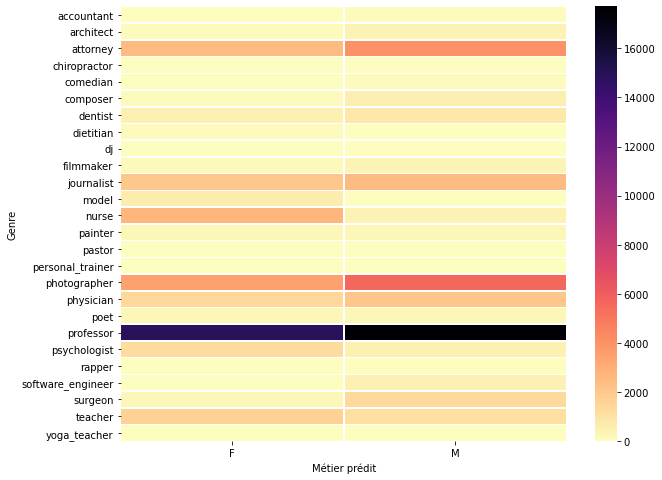

In [54]:
plot_heatmap(nb1_crossDispImp, "Genre", "Métier prédit", fmt='.2%')

In [55]:
nb1_avgDi = avgDi(nb1_crossDispImp)

--------------------------------
job: accountant
corresponding crosstab:
**************************************
gender          F      M
others      32629  39014
accountant     61     86
**************************************

disparate impact of accountant: 0.8483854674283438
--------------------------------
job: architect
corresponding crosstab:
**************************************
gender         F      M
others     32629  39014
architect     99    443
**************************************

disparate impact of architect: 0.2694238660761138
--------------------------------
job: attorney
corresponding crosstab:
**************************************
gender        F      M
others    32629  39014
attorney   2535   4033
**************************************

disparate impact of attorney: 0.7694747276499988
--------------------------------
job: chiropractor
corresponding crosstab:
**************************************
gender            F      M
others        32629  39014
chiropractor 

<ipython-input-40-24b0addd4d1d>:11: RuntimeWarning: divide by zero encountered in double_scalars
  DI = (tab_np[1,0] / (tab_np[1,0] + tab_np[0,0])) / (tab_np[1,1] / (tab_np[1,1] + tab_np[0,1]))
<ipython-input-40-24b0addd4d1d>:11: RuntimeWarning: divide by zero encountered in double_scalars
  DI = (tab_np[1,0] / (tab_np[1,0] + tab_np[0,0])) / (tab_np[1,1] / (tab_np[1,1] + tab_np[0,1]))


In [56]:
print(f"Le disparate impact moyen associé à ce premier modèle de Naive bayes multinomial est de {nb1_avgDi}.")

Le disparate impact moyen associé à ce premier modèle de Naive bayes multinomial est de inf.


#### *************Commentaire*************

On note que ce modèle naive bayes multinomial permet d'avoir un disparate impact infini. Ce n'est pas aberrant lorsqu'on considère le heatmap de la cellule précédente. En efet on y constate que pour certains métiers tels que professeur de yoga n'ont eu aucun CV d'homme prédit comme tel. Ceci a bien évidemment des imapcts sur le disparate impact et donc sur le modèle.

In [57]:
summary['Multinomial Naive Bayes'] = {
    "durée d'entrainement": tps1,
    "f1_score": nb1_f1_score,
    "disparate impact moyen" : nb1_avgDi
}

In [58]:
pd.concat([logreg1_crossDispImp, nb1_crossDispImp], axis=1, keys=["logReg1", "Nb1"])

logReg1             Nb1         
gender                  F      M        F        M
accountant            275    529     61.0     86.0
architect             364   1220     99.0    443.0
attorney             2455   4161   2535.0   4033.0
chiropractor           63    210      6.0      6.0
comedian               93    334     28.0     78.0
composer              168    950    100.0    582.0
dentist               610   1101    513.0    861.0
dietitian             621     32    101.0      6.0
dj                     20    160      1.0      3.0
filmmaker             356    841    199.0    407.0
interior_designer     143     29      NaN      NaN
journalist           2359   2522   2049.0   2514.0
model                1115    131    641.0     32.0
nurse                3592    259   2725.0    459.0
painter               685    685    238.0    226.0
paralegal             118     15      NaN      NaN
pastor                 84    276      3.0      3.0
personal_trainer       81     97      1.0      0.0
photographer         1891   3384   3503.0   5670.0
physician            1393   2221   1460.0   2138.0
poet                  622    593    307.0    245.0
professor           11078  14094  14814.0  17705.0
psychologist         1913   1045   1264.0    533.0
rapper                  8    159      1.0      3.0
software_engineer     130   1034     43.0    497.0
surgeon               218   1663    240.0   1376.0
teacher              1931   1230   1695.0   1108.0
yoga_teacher          243     39      2.0      0.0

### Random forest 

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
rfc1 = RandomForestClassifier(n_estimators=200, max_depth=4, random_state=0, class_weight="balanced")
rfc1

RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=200,
                       random_state=0)

In [61]:
tps0=time.perf_counter()

rfc1.fit(X_train, y_train)

tps1=(time.perf_counter()-tps0)

print(f"temps d'entrainement: {tps1}")

temps d'entrainement: 10.888435240999996


In [62]:
import pickle
filename = "../../Project_outputs/pickled_files/models/random_forest/model_1_trained_with_round1_cleaned_corpus_for_models.pkl"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
pickle.dump(rfc1, open(filename, 'wb'))

In [63]:
rfc1_y_pred = rfc1.predict(X_test)
rfc1_y_pred

array(['attorney', 'surgeon', 'filmmaker', ..., 'journalist', 'teacher',
       'filmmaker'], dtype=object)

In [64]:
print('accuracy %s' % accuracy_score(rfc1_y_pred, y_test))
print(classification_report(y_test, rfc1_y_pred, target_names=jobs))

accuracy 0.5317895677177115
                   precision    recall  f1-score   support

        professor       0.37      0.70      0.48      1050
       accountant       0.57      0.38      0.46      1918
        architect       0.78      0.68      0.73      6236
     psychologist       0.24      0.69      0.36       467
       journalist       0.17      0.70      0.27       566
          teacher       0.50      0.64      0.56      1161
            nurse       0.51      0.79      0.62      1790
         attorney       0.42      0.69      0.52       750
software_engineer       0.28      0.59      0.38       297
          painter       0.42      0.78      0.54      1344
        physician       0.15      0.78      0.26       282
     chiropractor       0.55      0.36      0.44      4085
 personal_trainer       0.43      0.38      0.40      1397
     photographer       0.64      0.61      0.62      4134
          surgeon       0.58      0.68      0.63      1463
        filmmaker       0.1

#### f1_score

In [65]:
rfc1_f1_score = f1_score(y_test, rfc1_y_pred, average='macro')
print('f1_score: %s' % rfc1_f1_score)

f1_score: 0.44393518386197545


#### Disparate impact

In [66]:
rfc1_crossDispImp = dispImpContTable(y_test, rfc1_y_pred, data1)
rfc1_crossDispImp

gender                F     M
predicted_job                
accountant          738  1282
architect           348   929
attorney           2065  3362
chiropractor        636   685
comedian            319  2041
composer            393  1095
dentist            1155  1612
dietitian           976   263
dj                  174   465
filmmaker           965  1547
interior_designer   862   568
journalist         1782   932
model               913   326
nurse              3108   843
painter             841   859
paralegal           843   491
pastor              305   680
personal_trainer    581   443
photographer       1273  2071
physician           967  1384
poet               1481  1375
professor          5600  7057
psychologist       1607   977
rapper              132  1926
software_engineer   277  1916
surgeon            1027  3087
teacher            1078   477
yoga_teacher       2183   321

In [67]:
rfc1_avgDi = avgDi(rfc1_crossDispImp)

--------------------------------
job: accountant
corresponding crosstab:
**************************************
gender          F      M
others      32629  39014
accountant    738   1282
**************************************

disparate impact of accountant: 0.6952053620850741
--------------------------------
job: architect
corresponding crosstab:
**************************************
gender         F      M
others     32629  39014
architect    348    929
**************************************

disparate impact of architect: 0.4537253726730569
--------------------------------
job: attorney
corresponding crosstab:
**************************************
gender        F      M
others    32629  39014
attorney   2065   3362
**************************************

disparate impact of attorney: 0.7502187819901897
--------------------------------
job: chiropractor
corresponding crosstab:
**************************************
gender            F      M
others        32629  39014
chiropractor 

In [68]:
print(f"Le disparate impact moyen associé à ce premier modèle de forêt aléatoire est de {rfc1_avgDi}.")

Le disparate impact moyen associé à ce premier modèle de forêt aléatoire est de 1.5533337915716066.


#### *************Commentaire*************

Avec le random forest on obtient un disparate impact moyen de 1.55 environ. En d'autres termes ce modèle est le plus "juste", le plus "loyal" selon le genre de l'individu à qui appartient le CV.

In [69]:
summary['Random Forest'] = {
    "durée d'entrainement": tps1,
    "f1_score": rfc1_f1_score,
    "disparate impact moyen" : rfc1_avgDi
}

In [70]:
pd.concat([logreg1_crossDispImp, nb1_crossDispImp, rfc1_crossDispImp], axis=1, keys=["logReg1", "Naive bayes", "random forest"])

logReg1        Naive bayes          random forest      
gender                  F      M           F        M             F     M
accountant            275    529        61.0     86.0           738  1282
architect             364   1220        99.0    443.0           348   929
attorney             2455   4161      2535.0   4033.0          2065  3362
chiropractor           63    210         6.0      6.0           636   685
comedian               93    334        28.0     78.0           319  2041
composer              168    950       100.0    582.0           393  1095
dentist               610   1101       513.0    861.0          1155  1612
dietitian             621     32       101.0      6.0           976   263
dj                     20    160         1.0      3.0           174   465
filmmaker             356    841       199.0    407.0           965  1547
interior_designer     143     29         NaN      NaN           862   568
journalist           2359   2522      2049.0   2514.0          1782   932
model                1115    131       641.0     32.0           913   326
nurse                3592    259      2725.0    459.0          3108   843
painter               685    685       238.0    226.0           841   859
paralegal             118     15         NaN      NaN           843   491
pastor                 84    276         3.0      3.0           305   680
personal_trainer       81     97         1.0      0.0           581   443
photographer         1891   3384      3503.0   5670.0          1273  2071
physician            1393   2221      1460.0   2138.0           967  1384
poet                  622    593       307.0    245.0          1481  1375
professor           11078  14094     14814.0  17705.0          5600  7057
psychologist         1913   1045      1264.0    533.0          1607   977
rapper                  8    159         1.0      3.0           132  1926
software_engineer     130   1034        43.0    497.0           277  1916
surgeon               218   1663       240.0   1376.0          1027  3087
teacher              1931   1230      1695.0   1108.0          1078   477
yoga_teacher          243     39         2.0      0.0          2183   321

### Linear Support Vector Machine

In [71]:
from sklearn.svm import LinearSVC

In [72]:
lsvc1 = LinearSVC(random_state=0, class_weight="balanced", max_iter=2000)
lsvc1

LinearSVC(class_weight='balanced', max_iter=2000, random_state=0)

In [73]:
tps0=time.perf_counter()

lsvc1.fit(X_train, y_train)

tps1=(time.perf_counter()-tps0)

print(f"temps d'entrainement: {tps1}")

temps d'entrainement: 22.769509665999976


In [74]:
import pickle
filename = "../../Project_outputs/pickled_files/models/linear_support_vector_machine/model_1_trained_with_round1_cleaned_corpus_for_models.pkl"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
pickle.dump(lsvc1, open(filename, 'wb'))

In [75]:
lsvc1_y_pred = lsvc1.predict(X_test)
lsvc1_y_pred

array(['attorney', 'professor', 'filmmaker', ..., 'journalist',
       'professor', 'filmmaker'], dtype=object)

In [76]:
print('accuracy %s' % accuracy_score(lsvc1_y_pred, y_test))
print(classification_report(y_test, lsvc1_y_pred, target_names=jobs))

accuracy 0.7802576664852114
                   precision    recall  f1-score   support

        professor       0.65      0.74      0.69      1050
       accountant       0.60      0.65      0.62      1918
        architect       0.87      0.87      0.87      6236
     psychologist       0.60      0.70      0.65       467
       journalist       0.64      0.72      0.68       566
          teacher       0.75      0.84      0.79      1161
            nurse       0.89      0.94      0.91      1790
         attorney       0.72      0.83      0.77       750
software_engineer       0.72      0.69      0.71       297
          painter       0.69      0.78      0.73      1344
        physician       0.59      0.69      0.63       282
     chiropractor       0.68      0.73      0.70      4085
 personal_trainer       0.69      0.77      0.73      1397
     photographer       0.86      0.81      0.83      4134
          surgeon       0.70      0.82      0.76      1463
        filmmaker       0.6

#### f1_score

In [77]:
lsvc1_f1_score = f1_score(y_test, lsvc1_y_pred, average='macro')
print('f1_score: %s' % lsvc1_f1_score)

f1_score: 0.712767267421513


#### Disparate impact

In [78]:
lsvc1_crossDispImp = dispImpContTable(y_test, lsvc1_y_pred, data1)
lsvc1_crossDispImp

gender                F      M
predicted_job                 
accountant          413    779
architect           506   1561
attorney           2361   3872
chiropractor        139    399
comedian            151    488
composer            224   1080
dentist             679   1194
dietitian           796     76
dj                   40    245
filmmaker           492   1036
interior_designer   256     74
journalist         2124   2236
model              1300    264
nurse              3586    332
painter             846    869
paralegal           225     48
pastor              202    521
personal_trainer    146    154
photographer       1724   3017
physician          1583   2293
poet                870    871
professor          8888  11209
psychologist       2253   1347
rapper               28    245
software_engineer   227   1365
surgeon             354   2083
teacher            1871   1282
yoga_teacher        345     74

In [79]:
lsvc1_avgDi = avgDi(lsvc1_crossDispImp)

--------------------------------
job: accountant
corresponding crosstab:
**************************************
gender          F      M
others      32629  39014
accountant    413    779
**************************************

disparate impact of accountant: 0.6384883082246666
--------------------------------
job: architect
corresponding crosstab:
**************************************
gender         F      M
others     32629  39014
architect    506   1561
**************************************

disparate impact of architect: 0.39693479212203064
--------------------------------
job: attorney
corresponding crosstab:
**************************************
gender        F      M
others    32629  39014
attorney   2361   3872
**************************************

disparate impact of attorney: 0.7473641081631351
--------------------------------
job: chiropractor
corresponding crosstab:
**************************************
gender            F      M
others        32629  39014
chiropractor

In [80]:
print(f"Le disparate impact moyen associé à ce premier modèle de linear support vector machine est de {lsvc1_avgDi}.")

Le disparate impact moyen associé à ce premier modèle de linear support vector machine est de 2.1765312173783538.


In [81]:
lsvc1_f1_score = f1_score(y_test, lsvc1_y_pred, average='macro')
print('f1_score: %s' % lsvc1_f1_score)

f1_score: 0.712767267421513


In [82]:
pd.concat([logreg1_crossDispImp, nb1_crossDispImp, rfc1_crossDispImp, lsvc1_crossDispImp], axis=1, keys=["logistic regression", "Naive bayes", "random forest", "linear support vector machine"])

logistic regression        Naive bayes           \
gender                              F      M           F        M   
accountant                        275    529        61.0     86.0   
architect                         364   1220        99.0    443.0   
attorney                         2455   4161      2535.0   4033.0   
chiropractor                       63    210         6.0      6.0   
comedian                           93    334        28.0     78.0   
composer                          168    950       100.0    582.0   
dentist                           610   1101       513.0    861.0   
dietitian                         621     32       101.0      6.0   
dj                                 20    160         1.0      3.0   
filmmaker                         356    841       199.0    407.0   
interior_designer                 143     29         NaN      NaN   
journalist                       2359   2522      2049.0   2514.0   
model                            1115    131       641.0     32.0   
nurse                            3592    259      2725.0    459.0   
painter                           685    685       238.0    226.0   
paralegal                         118     15         NaN      NaN   
pastor                             84    276         3.0      3.0   
personal_trainer                   81     97         1.0      0.0   
photographer                     1891   3384      3503.0   5670.0   
physician                        1393   2221      1460.0   2138.0   
poet                              622    593       307.0    245.0   
professor                       11078  14094     14814.0  17705.0   
psychologist                     1913   1045      1264.0    533.0   
rapper                              8    159         1.0      3.0   
software_engineer                 130   1034        43.0    497.0   
surgeon                           218   1663       240.0   1376.0   
teacher                          1931   1230      1695.0   1108.0   
yoga_teacher                      243     39         2.0      0.0   

                  random forest       linear support vector machine         
gender                        F     M                             F      M  
accountant                  738  1282                           413    779  
architect                   348   929                           506   1561  
attorney                   2065  3362                          2361   3872  
chiropractor                636   685                           139    399  
comedian                    319  2041                           151    488  
composer                    393  1095                           224   1080  
dentist                    1155  1612                           679   1194  
dietitian                   976   263                           796     76  
dj                          174   465                            40    245  
filmmaker                   965  1547                           492   1036  
interior_designer           862   568                           256     74  
journalist                 1782   932                          2124   2236  
model                       913   326                          1300    264  
nurse                      3108   843                          3586    332  
painter                     841   859                           846    869  
paralegal                   843   491                           225     48  
pastor                      305   680                           202    521  
personal_trainer            581   443                           146    154  
photographer               1273  2071                          1724   3017  
physician                   967  1384                          1583   2293  
poet                       1481  1375                           870    871  
professor                  5600  7057                          8888  11209  
psychologist               1607   977                          2253   1347  
rapper                

In [83]:
summary['Linear Support Vector Machine'] = {
    "durée d'entrainement": tps1,
    "f1_score": lsvc1_f1_score,
    "disparate impact moyen" : lsvc1_avgDi
}

## Récapitulatif

In [84]:
summary

{'logisitic regression': {"durée d'entrainement": 193.46162109,
  'f1_score': 0.7307200879711715,
  'disparate impact moyen': 3.069731944642231},
 'Multinomial Naive Bayes': {"durée d'entrainement": 0.8714994149999882,
  'f1_score': 0.383118535212719,
  'disparate impact moyen': inf},
 'Random Forest': {"durée d'entrainement": 10.888435240999996,
  'f1_score': 0.44393518386197545,
  'disparate impact moyen': 1.5533337915716066},
 'Linear Support Vector Machine': {"durée d'entrainement": 22.769509665999976,
  'f1_score': 0.712767267421513,
  'disparate impact moyen': 2.1765312173783538}}

In [85]:
df_summary = pd.DataFrame(summary)
df_summary

logisitic regression  Multinomial Naive Bayes  \
durée d'entrainement              193.461621                 0.871499   
f1_score                            0.730720                 0.383119   
disparate impact moyen              3.069732                      inf   

                        Random Forest  Linear Support Vector Machine  
durée d'entrainement        10.888435                      22.769510  
f1_score                     0.443935                       0.712767  
disparate impact moyen       1.553334                       2.176531

In [86]:
filename = "../../Project_outputs/csv_files/round1_models_summary.csv"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
df_summary.to_csv(filename, index=True,header=True)